# IMDB Reviews Sentiment Classification

The IMDB Reviews dataset is a dataset for binary sentiment classification.

## Imports

In [1]:
from html.parser import HTMLParser
from io import StringIO
import matplotlib.pyplot as plt
from official.nlp import optimization
import re
import string
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_text as text

## Helper Functions

In [2]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def strip_example_tags(text, label):
    print(text[0])
    return strip_tags(text), label

def plot_training_metrics(history):
    plt.figure(facecolor=(1, 1, 1, 1), figsize=(12, 8)) # My notebook is in dark mode
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.suptitle('Model Training')
    plt.legend()
    plt.show()

def save_best_model(model, test_ds, filename):
    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['accuracy'] > saved_model_metrics['accuracy']:
            model.save(filename, save_traces=False)
    else:
        model.save(filename, save_traces=False)

## Loading the Dataset

We split the testing set into a testing and validation set

In [3]:
(train_ds, test_ds, validation_ds), ds_info = tfds.load('imdb_reviews', as_supervised=True, split=['train', 'test[:50%]', 'test[50%:]'], with_info=True)
num_testing_examples = test_ds.cardinality()
num_training_examples = train_ds.cardinality()
num_validation_examples = validation_ds.cardinality()
print(f'Number of Training Examples: {num_training_examples}')
print(f'Number of Validation Examples: {num_validation_examples}')
print(f'Number of Testing Examples: {num_testing_examples}')
print('Sample Reviews:')
for review, label in train_ds.take(3):
    print('Review:', review.numpy().decode())
    print('Label:', label.numpy())

Number of Training Examples: 25000
Number of Validation Examples: 12500
Number of Testing Examples: 12500
Sample Reviews:
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfo

## Preparing the Dataset

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
buffer_size = 10000

test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)

validation_ds = validation_ds.cache()
validation_ds = validation_ds.batch(batch_size)
validation_ds = validation_ds.prefetch(AUTOTUNE)

## Creating a Text Encoder

In [5]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<[^<]+?>', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [6]:
vocab_size = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size,
    standardize=custom_standardization
)
encoder.adapt(train_ds.map(lambda text, label: text))
print('Vocabulary:', encoder.get_vocabulary()[:20])
for example, label in train_ds.take(1):
    print('Encoded Example:')
    print(encoder(example).numpy())

Vocabulary: ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film']
Encoded Example:
[[530  26   1 ...   0   0   0]
 [  2   1 382 ...   0   0   0]
 [ 10 407   9 ...   0   0   0]
 ...
 [  1   5   2 ...   0   0   0]
 [ 38 153   1 ...   0   0   0]
 [ 11  19   7 ...   0   0   0]]


## Comparing Model Types

### Simple/Vanilla RNN

#### Creating the Model

In [7]:
simple_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        mask_zero=True,
        output_dim=64
    ),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

simple_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

#### Training the Model

In [8]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
simple_history = simple_model.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=validation_ds,
    validation_steps=30
)

Epoch 1/100
391/391 [==============================] - 521s 1s/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6919 - val_accuracy: 0.5057
Epoch 2/100
391/391 [==============================] - 517s 1s/step - loss: 0.6890 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.5057
Epoch 3/100
391/391 [==============================] - 518s 1s/step - loss: 0.6760 - accuracy: 0.5151 - val_loss: 0.6349 - val_accuracy: 0.6318
Epoch 4/100
391/391 [==============================] - 515s 1s/step - loss: 0.6531 - accuracy: 0.5460 - val_loss: 0.6393 - val_accuracy: 0.6474
Epoch 5/100
391/391 [==============================] - 509s 1s/step - loss: 0.5158 - accuracy: 0.7115 - val_loss: 0.4299 - val_accuracy: 0.8016
Epoch 6/100
391/391 [==============================] - 528s 1s/step - loss: 0.3832 - accuracy: 0.8311 - val_loss: 0.3743 - val_accuracy: 0.8495
Epoch 7/100
391/391 [==============================] - 519s 1s/step - loss: 0.3477 - accuracy: 0.8478 - val_loss: 0.3624 - val_accuracy:

#### Plotting Training Metrics

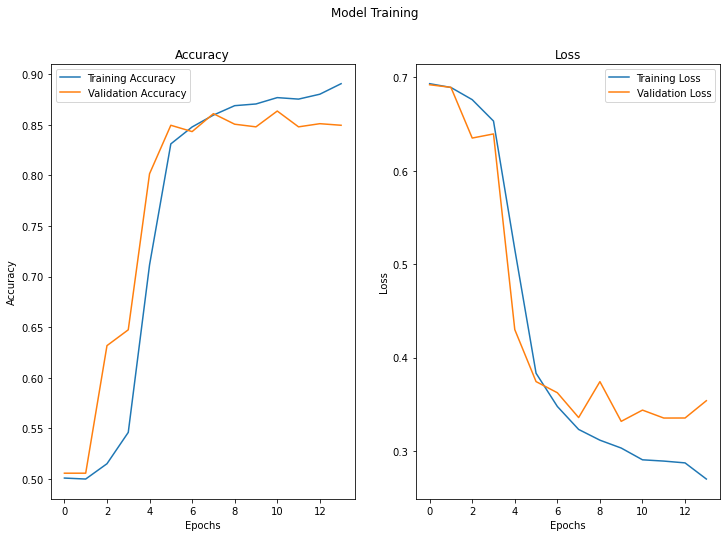

In [9]:
plot_training_metrics(simple_history)

#### Saving the Best Model

In [16]:
save_best_model(simple_model, test_ds, 'Simple_RNN')

Saved Model Evaluation:
196/196 [==============================] - 35s 176ms/step - loss: 0.3564 - accuracy: 0.8560
New Model Evaluation:
196/196 [==============================] - 33s 166ms/step - loss: 0.3564 - accuracy: 0.8560


### GRU

#### Creating the Model

In [11]:
gru_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        mask_zero=True,
        output_dim=64
    ),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
gru_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

#### Training the Model

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
gru_history = gru_model.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=validation_ds
)

Epoch 1/100
391/391 [==============================] - 35s 74ms/step - loss: 0.6899 - accuracy: 0.5000 - val_loss: 0.6756 - val_accuracy: 0.4967
Epoch 2/100
391/391 [==============================] - 28s 71ms/step - loss: 0.4841 - accuracy: 0.7460 - val_loss: 0.3693 - val_accuracy: 0.8338
Epoch 3/100
391/391 [==============================] - 28s 71ms/step - loss: 0.3509 - accuracy: 0.8476 - val_loss: 0.3397 - val_accuracy: 0.8498
Epoch 4/100
391/391 [==============================] - 27s 70ms/step - loss: 0.3242 - accuracy: 0.8636 - val_loss: 0.3237 - val_accuracy: 0.8591
Epoch 5/100
391/391 [==============================] - 27s 69ms/step - loss: 0.3151 - accuracy: 0.8676 - val_loss: 0.3184 - val_accuracy: 0.8629
Epoch 6/100
391/391 [==============================] - 27s 69ms/step - loss: 0.3089 - accuracy: 0.8698 - val_loss: 0.3183 - val_accuracy: 0.8634
Epoch 7/100
391/391 [==============================] - 26s 68ms/step - loss: 0.3053 - accuracy: 0.8714 - val_loss: 0.3174 - val_ac

#### Plotting Training Metrics

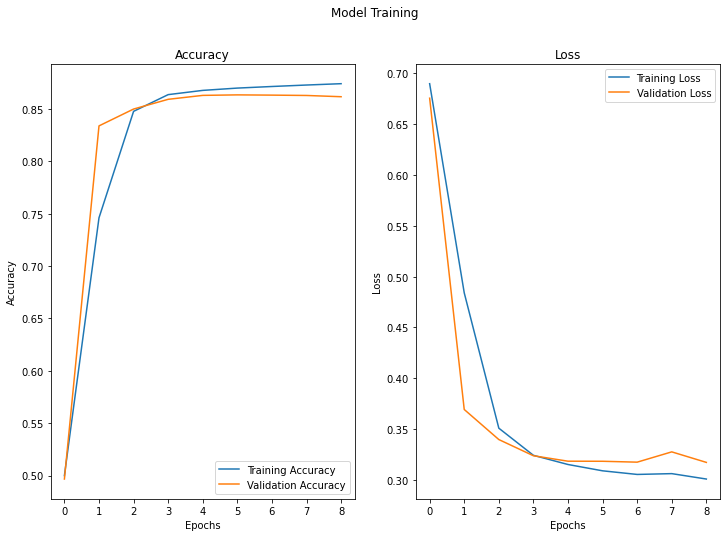

In [13]:
plot_training_metrics(gru_history)

#### Saving the Best Model

In [17]:
save_best_model(gru_model, test_ds, 'GRU')

Saved Model Evaluation:
196/196 [==============================] - 7s 29ms/step - loss: 0.3180 - accuracy: 0.8658
New Model Evaluation:
196/196 [==============================] - 6s 29ms/step - loss: 0.3180 - accuracy: 0.8658


### LSTM

#### Creating the Model

In [18]:
lstm_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        mask_zero=True,
        output_dim=64
    ),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

#### Training the Model

In [19]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
lstm_history = lstm_model.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=validation_ds
)

Epoch 1/100
391/391 [==============================] - 34s 76ms/step - loss: 0.6423 - accuracy: 0.5690 - val_loss: 0.4927 - val_accuracy: 0.7724
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 0.4139 - accuracy: 0.8153 - val_loss: 0.3565 - val_accuracy: 0.8395
Epoch 3/100
391/391 [==============================] - 28s 72ms/step - loss: 0.3448 - accuracy: 0.8542 - val_loss: 0.3338 - val_accuracy: 0.8520
Epoch 4/100
391/391 [==============================] - 28s 72ms/step - loss: 0.3248 - accuracy: 0.8632 - val_loss: 0.3223 - val_accuracy: 0.8654
Epoch 5/100
391/391 [==============================] - 28s 71ms/step - loss: 0.3121 - accuracy: 0.8694 - val_loss: 0.3173 - val_accuracy: 0.8630
Epoch 6/100
391/391 [==============================] - 27s 70ms/step - loss: 0.3080 - accuracy: 0.8715 - val_loss: 0.3162 - val_accuracy: 0.8609
Epoch 7/100
391/391 [==============================] - 27s 69ms/step - loss: 0.3041 - accuracy: 0.8742 - val_loss: 0.3151 - val_ac

#### Plotting Training Metrics

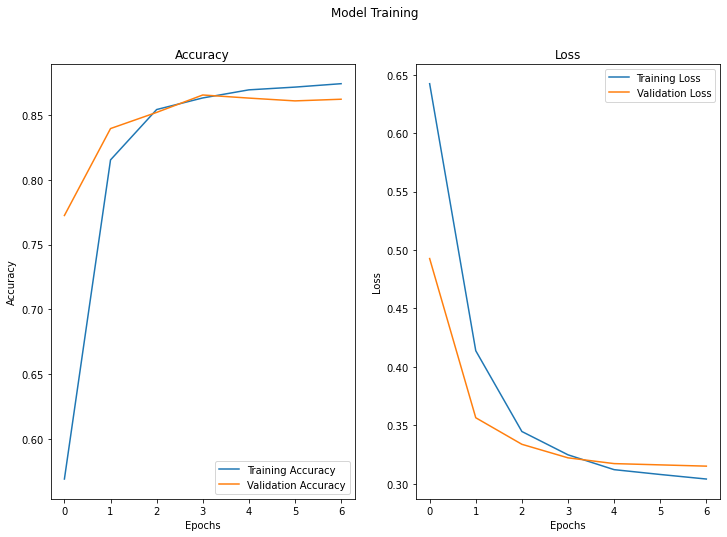

In [20]:
plot_training_metrics(lstm_history)

#### Saving the Best Model

In [27]:
save_best_model(lstm_model, test_ds, 'LSTM')

Saved Model Evaluation:
196/196 [==============================] - 7s 28ms/step - loss: 0.3240 - accuracy: 0.8676
New Model Evaluation:
196/196 [==============================] - 5s 28ms/step - loss: 0.3240 - accuracy: 0.8676


### Bidrectional Simple RNN

#### Creating the Model

In [22]:
bidirectional_simple_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        mask_zero=True,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
bidirectional_simple_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

#### Training the Model

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
bidirectional_simple_history = bidirectional_simple_model.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=validation_ds
)

Epoch 1/100
391/391 [==============================] - 1036s 3s/step - loss: 0.6796 - accuracy: 0.5158 - val_loss: 0.6124 - val_accuracy: 0.6697
Epoch 2/100
391/391 [==============================] - 1026s 3s/step - loss: 0.5121 - accuracy: 0.7299 - val_loss: 0.4895 - val_accuracy: 0.7400
Epoch 3/100
391/391 [==============================] - 1018s 3s/step - loss: 0.3735 - accuracy: 0.8334 - val_loss: 0.3599 - val_accuracy: 0.8468
Epoch 4/100
391/391 [==============================] - 1007s 3s/step - loss: 0.3388 - accuracy: 0.8531 - val_loss: 0.3408 - val_accuracy: 0.8498
Epoch 5/100
391/391 [==============================] - 1045s 3s/step - loss: 0.3182 - accuracy: 0.8641 - val_loss: 0.3404 - val_accuracy: 0.8454
Epoch 6/100
391/391 [==============================] - 1042s 3s/step - loss: 0.3032 - accuracy: 0.8709 - val_loss: 0.3278 - val_accuracy: 0.8512
Epoch 7/100
391/391 [==============================] - 1061s 3s/step - loss: 0.2945 - accuracy: 0.8733 - val_loss: 0.3274 - val_ac

#### Plotting Training Metrics

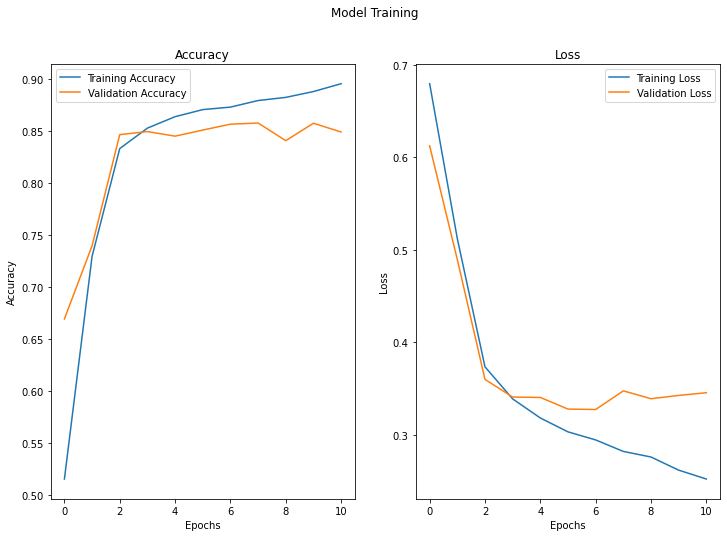

In [28]:
plot_training_metrics(bidirectional_simple_history)

#### Saving the Best Model

In [31]:
save_best_model(bidirectional_simple_model, test_ds, 'Bidirectional_Simple_RNN')

Saved Model Evaluation:
196/196 [==============================] - 62s 314ms/step - loss: 0.3449 - accuracy: 0.8609
New Model Evaluation:
196/196 [==============================] - 61s 314ms/step - loss: 0.3449 - accuracy: 0.8609


### Bidirectional GRU

#### Creating the Model

In [32]:
bidirectional_gru = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        mask_zero=True,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
bidirectional_gru.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

#### Training the Model

In [33]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
bidirectional_gru_history = bidirectional_gru.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=validation_ds
)

Epoch 1/100
391/391 [==============================] - 60s 133ms/step - loss: 0.6878 - accuracy: 0.5001 - val_loss: 0.6562 - val_accuracy: 0.5003
Epoch 2/100
391/391 [==============================] - 52s 133ms/step - loss: 0.4825 - accuracy: 0.7510 - val_loss: 0.4121 - val_accuracy: 0.8247
Epoch 3/100
391/391 [==============================] - 51s 130ms/step - loss: 0.3510 - accuracy: 0.8437 - val_loss: 0.3296 - val_accuracy: 0.8570
Epoch 4/100
391/391 [==============================] - 52s 134ms/step - loss: 0.3219 - accuracy: 0.8585 - val_loss: 0.3285 - val_accuracy: 0.8410
Epoch 5/100
391/391 [==============================] - 50s 128ms/step - loss: 0.3108 - accuracy: 0.8641 - val_loss: 0.3146 - val_accuracy: 0.8602
Epoch 6/100
391/391 [==============================] - 49s 125ms/step - loss: 0.3065 - accuracy: 0.8674 - val_loss: 0.3142 - val_accuracy: 0.8597
Epoch 7/100
391/391 [==============================] - 50s 129ms/step - loss: 0.3011 - accuracy: 0.8701 - val_loss: 0.3171 -

#### Plotting Training Metrics

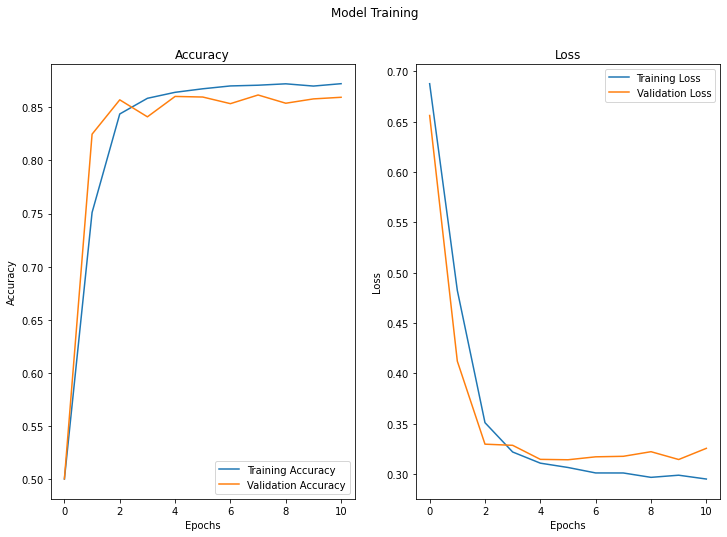

In [34]:
plot_training_metrics(bidirectional_gru_history)

#### Saving the Best Model

In [40]:
save_best_model(bidirectional_gru, test_ds, 'Bidirectional_GRU')

Saved Model Evaluation:
196/196 [==============================] - 12s 52ms/step - loss: 0.3189 - accuracy: 0.8647
New Model Evaluation:
196/196 [==============================] - 10s 52ms/step - loss: 0.3189 - accuracy: 0.8647


### Bidirectional LSTM

#### Creating the Model

In [51]:
bidirectional_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        mask_zero=True,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
bidirectional_lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

#### Training the Model

In [52]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
bidirectional_lstm_history = bidirectional_lstm.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=validation_ds
)

Epoch 1/100
391/391 [==============================] - 66s 146ms/step - loss: 0.5983 - accuracy: 0.6110 - val_loss: 0.4358 - val_accuracy: 0.7774
Epoch 2/100
391/391 [==============================] - 56s 143ms/step - loss: 0.3621 - accuracy: 0.8400 - val_loss: 0.3280 - val_accuracy: 0.8494
Epoch 3/100
391/391 [==============================] - 55s 141ms/step - loss: 0.3239 - accuracy: 0.8614 - val_loss: 0.3202 - val_accuracy: 0.8500
Epoch 4/100
391/391 [==============================] - 54s 139ms/step - loss: 0.3114 - accuracy: 0.8642 - val_loss: 0.3128 - val_accuracy: 0.8588
Epoch 5/100
391/391 [==============================] - 54s 139ms/step - loss: 0.3067 - accuracy: 0.8672 - val_loss: 0.3129 - val_accuracy: 0.8572
Epoch 6/100
391/391 [==============================] - 54s 139ms/step - loss: 0.3018 - accuracy: 0.8712 - val_loss: 0.3128 - val_accuracy: 0.8562
Epoch 7/100
391/391 [==============================] - 55s 141ms/step - loss: 0.2977 - accuracy: 0.8725 - val_loss: 0.3148 -

#### Plotting Training Metrics

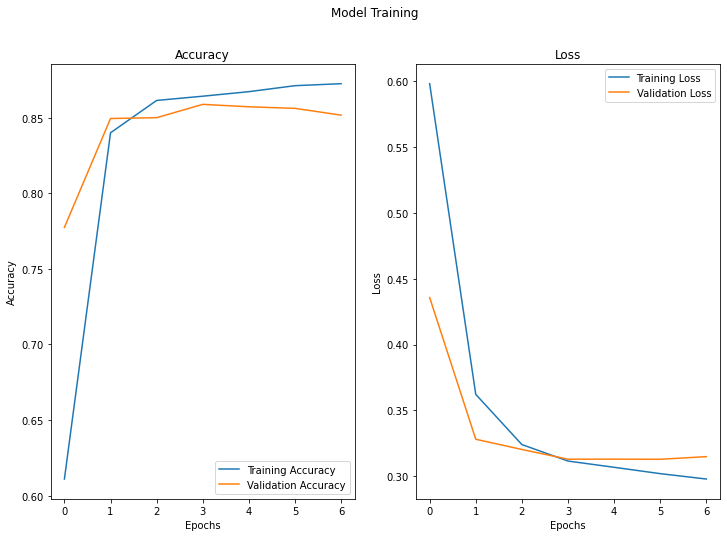

In [53]:
plot_training_metrics(bidirectional_lstm_history)

#### Saving the Best Model

In [54]:
save_best_model(bidirectional_lstm, test_ds, 'Bidirectional_LSTM')

Saved Model Evaluation:
196/196 [==============================] - 12s 50ms/step - loss: 0.3188 - accuracy: 0.8650
New Model Evaluation:
196/196 [==============================] - 10s 53ms/step - loss: 0.3118 - accuracy: 0.8606


Interestingly, on this task, all models achieve an essentially identical accuracy, not differing by much more than a percent of accuracy on the test set. This apparent limit also withstands changing model parameters, from layer size and number to embedding dimension. This example also shows that simple/vanilla RNNs take an order of magnitude longer to train than GRUs and LSTMs.

### Transfer Learning Approach

For transfer learning we use the base BERT model due to the limitations of training on a single GPU

#### Loading and Processing the Data

In [4]:
(train_ds, test_ds, validation_ds), ds_info = tfds.load('imdb_reviews', as_supervised=True, split=['train', 'test[:50%]', 'test[50%:]'], with_info=True)

def reshape_string(string, label):
    '''
    This makes the first dimension None, which is required by the input layer
    '''
    return tf.compat.v1.placeholder_with_default(string, shape=tf.TensorShape([None]).concatenate(string.shape)[1:]), label

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
buffer_size = 10000

test_ds = test_ds.map(reshape_string, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

train_ds = train_ds.map(reshape_string, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)

validation_ds = validation_ds.map(reshape_string, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.cache()
validation_ds = validation_ds.batch(batch_size)
validation_ds = validation_ds.prefetch(AUTOTUNE)

#### Creating the Model

In [8]:
bert_preprocessing = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', trainable=True) # Smallest available BERT
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2', trainable=True) # Intermediate sized BERT
# bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True) # Base BERT
# bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/2', trainable=True) # BERT with talking-heads attention and gated GELU

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
bert_inputs = bert_preprocessing(text_input)
bert_outputs = bert_model(bert_inputs)
bert_pooled_output = bert_outputs['pooled_output']
bert_dropout_layer = tf.keras.layers.Dropout(0.1)(bert_pooled_output)
final_output = tf.keras.layers.Dense(1)(bert_dropout_layer)
transfer_model = tf.keras.Model(text_input, final_output)

epochs = 5
steps_per_epoch = train_ds.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

transfer_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=optimization.create_optimizer( # This is the same optimizer that BERT models were originally trained with
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')
)
transfer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      {'input_mask': (None 0           input_3[0][0]                    
__________________________________________________________________________________________________
keras_layer_6 (KerasLayer)      {'default': (None, 5 41373185    keras_layer_4[0][0]              
                                                                 keras_layer_4[0][1]              
                                                                 keras_layer_4[0][2]              
____________________________________________________________________________________________

In [9]:
transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds
)

Epoch 1/5
1563/1563 [==============================] - 516s 325ms/step - loss: 0.4354 - accuracy: 0.7802 - val_loss: 0.3504 - val_accuracy: 0.8361
Epoch 2/5
1563/1563 [==============================] - 508s 325ms/step - loss: 0.2844 - accuracy: 0.8822 - val_loss: 0.3631 - val_accuracy: 0.8528
Epoch 3/5
1563/1563 [==============================] - 508s 325ms/step - loss: 0.1833 - accuracy: 0.9344 - val_loss: 0.5095 - val_accuracy: 0.8663
Epoch 4/5
1563/1563 [==============================] - 503s 322ms/step - loss: 0.1211 - accuracy: 0.9664 - val_loss: 0.6471 - val_accuracy: 0.8610
Epoch 5/5
1563/1563 [==============================] - 497s 318ms/step - loss: 0.0755 - accuracy: 0.9803 - val_loss: 0.7194 - val_accuracy: 0.8638


#### Plotting Training Results and Saving the Best Model

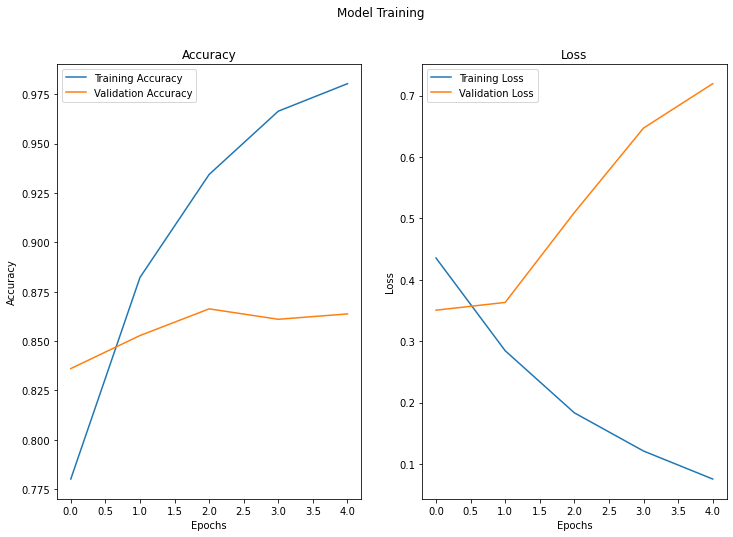

INFO:tensorflow:Assets written to: Transfer_Model\assets


INFO:tensorflow:Assets written to: Transfer_Model\assets


In [11]:
plot_training_metrics(transfer_history)
save_best_model(transfer_model, test_ds, 'Transfer_Model')